## London Property Sales Price Analysis

- Data sources: HM Land Registry Price Paid Data and Energy Performance Certificates (EPCs)


*Contains HM Land Registry data and Energy Performance Certificates data © Crown copyright and database right 2021. This data is licensed under the Open Government Licence v3.0.*

#### Price Paid Data Download

In [ ]:
!mkdir data

In [1]:
!wget -P data http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv

In [2]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import requests
import os
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### Price Paid Data Dictionary

Web-scaped from
https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd


In [3]:
url = "https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd"
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

element = soup.find('table')

rows = element.find_all('tr')

headers = [header.text for header in rows[0].find_all('th')]

data = []
for row in rows[1:]:
    data.append([col.text for col in row.find_all('td')])

col1data = []
col2data = []
for row in rows[1:]:
    col1data.append([col.text for col in row.find_all('th')])
    col2data.append([col.text for col in row.find_all('td')])

dat1 = pd.DataFrame(col1data, columns=headers[:1])
dat2 = pd.DataFrame(col2data, columns=headers[1:])

pp_dictionary = pd.concat([dat1,dat2],axis=1)

pp_dictionary

,Data item,Explanation (where appropriate)
0,Transaction unique identifier,A reference number which is generated automati...
1,Price,Sale price stated on the transfer deed.
2,Date of Transfer,"Date when the sale was completed, as stated on..."
3,Postcode,This is the postcode used at the time of the o...
4,Property Type,"D = Detached, S = Semi-Detached, T = Terraced,..."
5,Old/New,Indicates the age of the property and applies ...
6,Duration,"Relates to the tenure: F = Freehold, L= Leaseh..."
7,PAON,Primary Addressable Object Name. Typically the...
8,SAON,Secondary Addressable Object Name. Where a pro...
9,Street,


#### Price Paid Data Cleaning

In [4]:
# price paid data file path
PP_FILE_PATH ="data/pp-complete.csv"

In [5]:
spark = SparkSession.builder.appName('housesalesdata').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/14 13:07:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
pp_raw = spark.read.csv(PP_FILE_PATH, inferSchema=True, header=False)

In [ ]:
headers = ['TRANSACTION_UNIQUE_IDENTIFIER','PRICE',
           'DATE_OF_TRANSFER','POSTCODE','PROPERTY_TYPE',
           'OLD_NEW','DURATION','PAON','SAON','STREET',
           'LOCALITY','TOWN_CITY','DISTRICT','COUNTY',
           'PPD_CATEGORY_TYPE','RECORD_STATUS_MONTHLY_FILE_ONLY']
pp_raw = pp_raw.toDF(*headers)

In [8]:
pp_raw.count()

28634236

In [9]:
pp_raw.select(
    F.min('DATE_OF_TRANSFER').alias('min_date'),
    F.max('DATE_OF_TRANSFER').alias('max_date')
         ).show()

+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|1995-01-01 00:00:00|2023-09-29 00:00:00|
+-------------------+-------------------+



###### Extraction, EDA and cleaning of London Data

Only data from 2020 is used for this analysis

In [10]:
london_raw = pp_raw.filter(F.col('COUNTY')=='GREATER LONDON')\
    .filter(F.col('DATE_OF_TRANSFER')>='2010-01-01')

In [11]:
london_raw.select(F.count('TRANSACTION_UNIQUE_IDENTIFIER').alias('cnt'),
                F.count_distinct('TRANSACTION_UNIQUE_IDENTIFIER').alias('dcnt')).show()

+-------+-------+
|    cnt|   dcnt|
+-------+-------+
|1494250|1494250|
+-------+-------+



Removing records with missing postcode

In [ ]:
london_raw.filter(F.col("POSTCODE").isNull()).count()

4623

In [17]:
london_raw = london_raw.filter(F.col("POSTCODE").isNotNull())

In [18]:
london_raw.columns

['TRANSACTION_UNIQUE_IDENTIFIER',
 'PRICE',
 'DATE_OF_TRANSFER',
 'POSTCODE',
 'PROPERTY_TYPE',
 'OLD_NEW',
 'DURATION',
 'PAON',
 'SAON',
 'STREET',
 'LOCALITY',
 'TOWN_CITY',
 'DISTRICT',
 'COUNTY',
 'PPD_CATEGORY_TYPE',
 'RECORD_STATUS_MONTHLY_FILE_ONLY']

In [54]:
byDistrict = london_raw.groupby('DISTRICT').agg(F.count_distinct('TRANSACTION_UNIQUE_IDENTIFIER').alias('cnt')).toPandas()

In [55]:
byDistrict = byDistrict.nlargest(n=10, columns='cnt')

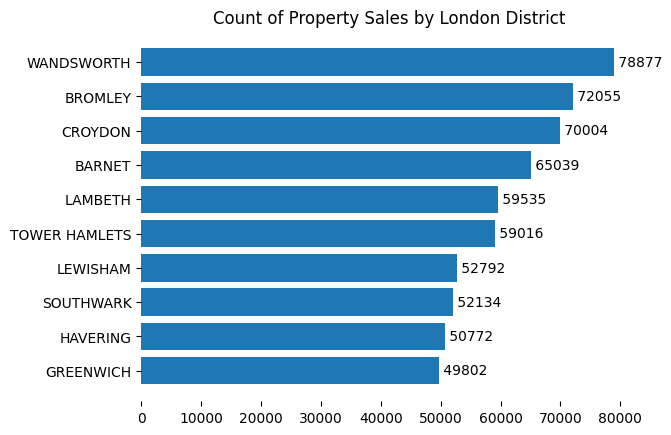

In [69]:
fig, ax = plt.subplots()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

width=byDistrict['cnt']
y=byDistrict['DISTRICT']
title='Count of Property Sales by London District'

ax.barh(y=y, width=width)
ax.invert_yaxis()
ax.set_title(title)

for index, value in enumerate(width):
    ax.text(value, index, " "+str(value),va='center')

In [70]:
pp_london = london_raw.toPandas()

In [71]:
pp_london.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1489627 entries, 0 to 1489626
Data columns (total 16 columns):
 #   Column                           Non-Null Count    Dtype         
---  ------                           --------------    -----         
 0   TRANSACTION_UNIQUE_IDENTIFIER    1489627 non-null  object        
 1   PRICE                            1489627 non-null  int32         
 2   DATE_OF_TRANSFER                 1489627 non-null  datetime64[ns]
 3   POSTCODE                         1489627 non-null  object        
 4   PROPERTY_TYPE                    1489627 non-null  object        
 5   OLD_NEW                          1489627 non-null  object        
 6   DURATION                         1489627 non-null  object        
 7   PAON                             1489621 non-null  object        
 8   SAON                             559561 non-null   object        
 9   STREET                           1489570 non-null  object        
 10  LOCALITY                      

## Load EPC data

---- EPC data for floor area
---- match



In [ ]:
# EPC data dowbloaded from
# https://epc.opendatacommunities.org/domestic/search
# Registration required.

In [ ]:
districts = pd.read_csv("data/Local_Authority_Districts_(April_2023)_Names_and_Codes_in_the_United_Kingdom.csv")
lon_boroughs = pd.read_csv("data/london_borough.csv") # from Wikipedia

lon_boroughs = lon_boroughs.rename(columns={"Borough":"LAD23NM"})

lon_districts = lon_boroughs.merge(districts[["LAD23NM","LAD23CD"]],
                  how="left",
                  on="LAD23NM")

lon_districts_set = set(lon_districts["LAD23CD"])

In [ ]:
fol = 'epc_data/'
lista = os.listdir(fol)

In [ ]:
cols_epc = ["ADDRESS","POSTCODE","TOTAL_FLOOR_AREA"]

dfs = []
for fol1 in lista:
    dist = fol1.split("-")[1]
    if dist in lon_districts_set:
        tmp = pd.read_csv(fol+fol1+"/certificates.csv",
                          usecols = cols_epc,
                          low_memory=False)
        dfs.append(tmp)

In [ ]:
london_epc = pd.concat(dfs, ignore_index=True)

### Reformat columns and merge

In [ ]:
def transform(df, cols:list):
    transformed_cols = []
    for c in cols:
        newc = c+"_fmt"
        df[newc] = df[c].str.strip()
        df[newc] = df[newc].str.lower()
        df[newc] = df[newc].str.replace(" ","")
        df[newc] = df[newc].str.replace(",","")
        transformed_cols.append(newc)
    return transformed_cols

In [ ]:
pp_cols = ["SAON", "PAON", "STREET","POSTCODE"]

transformed_cols_pp = transform(pp_london, pp_cols)

In [ ]:
pp_london["address_match_string"] = pp_london[transformed_cols_pp].fillna("").astype(str).agg(lambda x:''.join(x), axis=1)

In [ ]:
epc_cols = ['ADDRESS', 'POSTCODE']
transformed_cols_epc = transform(london_epc, epc_cols)

In [ ]:
london_epc["address_match_string"] = london_epc[transformed_cols_epc].fillna("").astype(str).agg(lambda x:''.join(x), axis=1)

## Cleaning london_epc

For the addresses that have multiple values for "TOTAL_FLOOR_AREA", I keep only the highest.

In [ ]:
london_epc["address_match_string"].value_counts()

In [ ]:
london_epc = london_epc.sort_values(["address_match_string","TOTAL_FLOOR_AREA"], ascending=False)\
    .drop_duplicates("address_match_string",keep='first')

In [ ]:
london_epc["address_match_string"].value_counts()

In [ ]:
# london_epc = london_epc.merge(london_epc["address_match_string"].value_counts().rename("count"),
#                  how='left',
#                  left_on="address_match_string",
#                  right_index=True)

In [ ]:
# london_epc[london_epc["count"]>1].sort_values("address_match_string")

### Merging

In [ ]:
len(pp_london)

In [ ]:
data_london = pp_london.merge(london_epc[["address_match_string", "TOTAL_FLOOR_AREA"]],
               how = 'left',
               on = "address_match_string")

In [ ]:
len(data_london)

In [ ]:
match_rate = (len(data_london[data_london["TOTAL_FLOOR_AREA"].notna()])/len(data_london))

In [ ]:
print(f'Match Rate: {round(match_rate*100)}%')

In [ ]:
data_london = data_london.drop(transformed_cols_pp+["address_match_string"],axis=1)

In [ ]:
data_london["PARTIAL_POSTCODE"] = data_london["POSTCODE"].str.split(expand=True)[0]

In [ ]:
data_london.info()

In [ ]:
pp_dictionary

In [ ]:
pp_dictionary[pp_dictionary["Data item"]=="Record Status - monthly file only"]["Explanation (where appropriate)"].values

In [ ]:
PROPERTY_TYPE_labels = {
    "D" : "Detached",
    "S" : "Semi-Detached",
    "T" : "Terraced",
    "F" : "Flats/Maisonettes",
    "O" : "Other"
}

data_london["PROPERTY_TYPE"] = data_london["PROPERTY_TYPE"].map(PROPERTY_TYPE_labels)

In [ ]:
old_new_labels = {
    "Y":"newly built",
    "N":"old"
}
data_london["OLD_NEW"] = data_london["OLD_NEW"].map(old_new_labels )

In [ ]:
duration_labels = {
    "F" : "Freehold", 
    "L" : "Leasehold"
}

data_london["DURATION"] = data_london["DURATION"].map(duration_labels)

In [ ]:
# data_london.to_parquet("data/london.gzip")
data_london.to_csv("data/london.csv", index=None)

In [ ]:
spark.stop()